In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import linalg

# Load the mnist data from file
# From https://stackoverflow.com/a/53226079
def loadMNIST( prefix, folder ):
    intType = np.dtype( 'int32' ).newbyteorder( '>' )
    nMetaDataBytes = 4 * intType.itemsize

    data = np.fromfile( folder + "/" + prefix + '-images-idx3-ubyte', dtype = 'ubyte' )
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )
    data = data[nMetaDataBytes:].astype( dtype = 'float32' ).reshape( [ nImages, width, height ] )

    labels = np.fromfile( folder + "/" + prefix + '-labels-idx1-ubyte',
                          dtype = 'ubyte' )[2 * intType.itemsize:]

    return data, labels


In [2]:
# Load Data from Files
trainingImages, trainingLabels = loadMNIST( "train", "./datasets" )
testImages, testLabels = loadMNIST( "t10k", "./datasets" )

train_labels = trainingLabels
test_labels = testLabels

# Swap axes
train_data = np.moveaxis(trainingImages, 0, -1)
test_data = np.moveaxis(testImages, 0, -1)

# Flatten images
train_data = np.reshape(train_data, (train_data.shape[0] * train_data.shape[1], train_data.shape[2]))
test_data = np.reshape(test_data, (test_data.shape[0] * test_data.shape[1], test_data.shape[2]))

# Rescale to [0, 1]
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [3]:
U, S, V = np.linalg.svd(train_data - np.mean(train_data, axis=1)[:, None], full_matrices=False)
#U, S, V = np.linalg.svd(train_data, full_matrices=False)

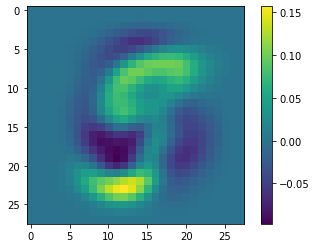

In [4]:
plt.imshow(np.reshape(U[:, 3], (28, 28)))
plt.colorbar()
plt.show()

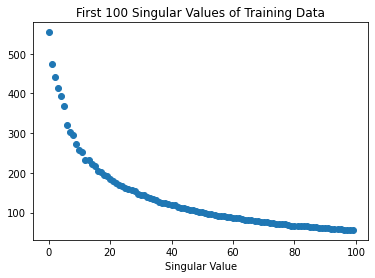

In [5]:
plt.plot(S[0:100], 'o')
plt.title("First 100 Singular Values of Training Data")
plt.xlabel("Singular Value")
plt.show()

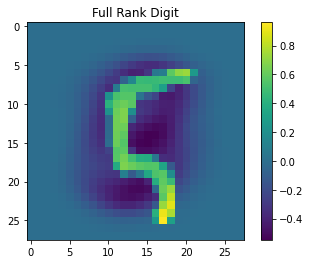

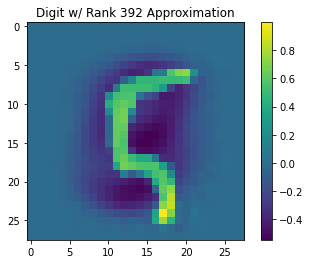

In [6]:
# Create low-rank approximation and visualize digits for comparison
rank = int(784/2)
img_num = 100

S_partial = np.copy(S)
S_partial[rank:] = 0
reconstruction = U @ np.diag(S_partial) @ V
original = U @ np.diag(S) @ V
plt.title("Full Rank Digit")
plt.imshow(np.reshape(original[:, img_num], (28, 28)))
plt.colorbar()
plt.show()
plt.title("Digit w/ Rank " + str(rank) + " Approximation")
plt.imshow(np.reshape(reconstruction[:, img_num], (28, 28)))
plt.colorbar()
plt.show()

In [13]:
projections = []
for i in range(10):
    projections.append(V[0:3, train_labels == i])
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(10):
    # Sample 100 points for each digit to make visualization better
    # Maybe don't do this, idk decide later
    indices = np.random.randint(projections[i].shape[1], size = 1000)
    
    data = projections[i][:, indices]
    #data = projections[i][:, :]
    
    ax.scatter(data[0, :], data[1, :], data[2, :], s=6)
plt.title("Digit Data Projected onto Right Singular Vectors")
ax.set_xlabel("1st Right Singular Vector")
ax.set_ylabel("2nd Right Singular Vector")
ax.set_zlabel("3rd Right Singular Vector")
ax.legend(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9"), loc="left")
plt.show()

In [8]:
def digit_trainer(digit1_data, digit2_data, num_features):
    U, S, V = np.linalg.svd(np.hstack((digit1_data, digit2_data)), full_matrices=False)
    U = U[:, 0:num_features]

    SV = np.diag(S) @ V
    digit1 = SV[0:num_features, :digit1_data.shape[1]]
    digit2 = SV[0:num_features, digit1_data.shape[1] + 1:]


    d1_m = np.mean(digit1, axis=1)
    d2_m = np.mean(digit2, axis=1)

    S_w = 0
    for i in range(digit1.shape[1]):
        S_w += (digit1[:, i] - d1_m).reshape(-1, 1) @ (digit1[:, i] - d1_m).reshape(-1, 1).T
    
    for i in range(digit2.shape[1]):
        S_w += (digit2[:, i] - d2_m).reshape(-1, 1) @ (digit2[:, i] - d2_m).reshape(-1, 1).T

    S_b = (d1_m - d2_m).reshape(-1, 1) @ (d1_m - d2_m).reshape(-1, 1).T

    eigenvalues, eigenvectors = sp.linalg.eig(S_b, S_w)
    max_eig_ind = np.argmax(np.abs(eigenvalues))
    w = eigenvectors[:, max_eig_ind]
    w = w / np.linalg.norm(w, ord=2)

    proj_d1 = w.T @ digit1
    proj_d2 = w.T @ digit2

    if np.mean(proj_d1) > np.mean(proj_d2):
        w = -w
        proj_d1 = -proj_d1
        proj_d2 = -proj_d2

    sort_d1 = np.sort(proj_d1)
    sort_d2 = np.sort(proj_d2)

    t1 = len(sort_d1) - 1
    t2 = 0

    while sort_d1[t1] > sort_d2[t2]:
        t1 -= 1
        t2 += 1

    threshold = (sort_d1[t1] + sort_d2[t2]) / 2

    return U, S, V, threshold, w


def predict(data, U, threshold, w, digits):
    prediction_val = w.T @ U.T @ data
    predictions = np.zeros(prediction_val.shape)
    predictions[prediction_val < threshold] = digits[0]
    predictions[prediction_val >= threshold] = digits[1]
    return predictions

def accuracy(predictions, labels):
    return np.sum(predictions == labels) / len(predictions)

In [9]:
num_features = 20
train_acc = np.zeros((10, 10))
test_acc = np.zeros((10, 10))
for i in range(10):
    for j in range(i + 1, 10):
        print("Testing " + str(i) + " vs " + str(j))

        train1 = train_data[:, train_labels == i]
        train2 = train_data[:, train_labels == j]

        train = train_data[:, (train_labels == i) | (train_labels == j)]
        train_l = train_labels[(train_labels == i) | (train_labels == j)]

        test = test_data[:, (test_labels == i) | (test_labels == j)]
        test_l = test_labels[(test_labels == i) | (test_labels == j)]

        U, S, V, threshold, w = digit_trainer(train1, train2, num_features=num_features)

        train_predictions = predict(train, U, threshold, w, [i, j])
        train_acc[i, j] = accuracy(train_predictions, train_l)

        test_predictions = predict(test, U, threshold, w, [i, j])
        test_acc[i, j] = accuracy(test_predictions, test_l)

Testing 0 vs 1
Testing 0 vs 2
Testing 0 vs 3
Testing 0 vs 4
Testing 0 vs 5
Testing 0 vs 6
Testing 0 vs 7
Testing 0 vs 8
Testing 0 vs 9
Testing 1 vs 2
Testing 1 vs 3
Testing 1 vs 4
Testing 1 vs 5
Testing 1 vs 6
Testing 1 vs 7
Testing 1 vs 8
Testing 1 vs 9
Testing 2 vs 3
Testing 2 vs 4
Testing 2 vs 5
Testing 2 vs 6
Testing 2 vs 7
Testing 2 vs 8
Testing 2 vs 9
Testing 3 vs 4
Testing 3 vs 5
Testing 3 vs 6
Testing 3 vs 7
Testing 3 vs 8
Testing 3 vs 9
Testing 4 vs 5
Testing 4 vs 6
Testing 4 vs 7
Testing 4 vs 8
Testing 4 vs 9
Testing 5 vs 6
Testing 5 vs 7
Testing 5 vs 8
Testing 5 vs 9
Testing 6 vs 7
Testing 6 vs 8
Testing 6 vs 9
Testing 7 vs 8
Testing 7 vs 9
Testing 8 vs 9
Wall time: 4min 23s


In [10]:
train_acc = np.ma.masked_array(train_acc, mask=(train_acc == 0))
test_acc = np.ma.masked_array(test_acc, mask=(test_acc == 0))

In [11]:
np.set_printoptions(suppress=False, precision=4)
train_acc_sort = np.unravel_index(np.ma.argsort(train_acc, axis=None, fill_value=10), train_acc.shape)
train_acc_sort = np.vstack(train_acc_sort).T[:45, :]
train_acc_val = np.zeros(train_acc_sort.shape[0])
for i in range(45):
    train_acc_val[i] = train_acc[train_acc_sort[i, 0], train_acc_sort[i, 1]]
print("Train Accuracies:")
print(np.hstack((train_acc_sort, train_acc_val.reshape(-1, 1))))

Train Accuracies:
[[3.     5.     0.9337]
 [7.     9.     0.9343]
 [5.     8.     0.9411]
 [4.     9.     0.9427]
 [3.     8.     0.9435]
 [2.     3.     0.9567]
 [2.     8.     0.9575]
 [8.     9.     0.9614]
 [2.     6.     0.965 ]
 [3.     9.     0.9666]
 [1.     8.     0.9678]
 [2.     5.     0.968 ]
 [2.     7.     0.9699]
 [5.     6.     0.9703]
 [5.     9.     0.9725]
 [2.     9.     0.9754]
 [2.     4.     0.9762]
 [3.     7.     0.9769]
 [0.     5.     0.9774]
 [4.     7.     0.978 ]
 [1.     2.     0.9793]
 [4.     8.     0.9808]
 [4.     5.     0.9814]
 [7.     8.     0.9815]
 [6.     8.     0.9821]
 [0.     2.     0.9823]
 [0.     8.     0.9823]
 [1.     3.     0.9829]
 [5.     7.     0.9844]
 [1.     5.     0.9854]
 [0.     6.     0.9857]
 [4.     6.     0.9866]
 [0.     3.     0.9867]
 [3.     4.     0.9875]
 [3.     6.     0.9876]
 [1.     7.     0.9879]
 [0.     9.     0.989 ]
 [1.     9.     0.9902]
 [1.     4.     0.993 ]
 [1.     6.     0.9938]
 [0.     4.     0.9943

In [12]:
test_acc_sort = np.unravel_index(np.ma.argsort(test_acc, axis=None, fill_value=10), test_acc.shape)
test_acc_sort = np.vstack(test_acc_sort).T[:45, :]
test_acc_val = np.zeros(test_acc_sort.shape[0])
for i in range(45):
    test_acc_val[i] = test_acc[test_acc_sort[i, 0], test_acc_sort[i, 1]]
print("Test Accuracies:")
print(np.hstack((test_acc_sort, test_acc_val.reshape(-1, 1))))

Test Accuracies:
[[4.     9.     0.9397]
 [5.     8.     0.9421]
 [3.     5.     0.9422]
 [7.     9.     0.9445]
 [3.     8.     0.9567]
 [8.     9.     0.9607]
 [2.     3.     0.9628]
 [2.     7.     0.965 ]
 [5.     6.     0.9676]
 [2.     8.     0.9676]
 [5.     9.     0.97  ]
 [3.     9.     0.9718]
 [2.     6.     0.9719]
 [3.     7.     0.972 ]
 [2.     5.     0.9725]
 [2.     4.     0.9757]
 [7.     8.     0.976 ]
 [4.     7.     0.9771]
 [2.     9.     0.9775]
 [1.     8.     0.9782]
 [6.     8.     0.9798]
 [0.     5.     0.9808]
 [4.     8.     0.9811]
 [0.     6.     0.9825]
 [5.     7.     0.9839]
 [4.     5.     0.9845]
 [1.     2.     0.9848]
 [4.     6.     0.9851]
 [0.     2.     0.9866]
 [0.     8.     0.9877]
 [1.     7.     0.988 ]
 [3.     6.     0.9893]
 [3.     4.     0.9905]
 [1.     3.     0.9921]
 [0.     9.     0.9925]
 [0.     7.     0.993 ]
 [1.     5.     0.9931]
 [1.     9.     0.9935]
 [1.     6.     0.9938]
 [6.     9.     0.9939]
 [0.     3.     0.994 ]

In [17]:
train_acc_mat = np.array(train_acc) + np.array(train_acc.T)
for i in range(train_acc_mat.shape[0]):
    train_acc_mat[i, i] = 1
print(train_acc_mat)

test_acc_mat = np.array(train_acc) + np.array(train_acc.T)
for i in range(test_acc_mat.shape[0]):
    test_acc_mat[i, i] = 1
print(test_acc_mat)

[[1.     0.9971 0.9823 0.9867 0.9943 0.9774 0.9857 0.9954 0.9823 0.989 ]
 [0.9971 1.     0.9793 0.9829 0.993  0.9854 0.9938 0.9879 0.9678 0.9902]
 [0.9823 0.9793 1.     0.9567 0.9762 0.968  0.965  0.9699 0.9575 0.9754]
 [0.9867 0.9829 0.9567 1.     0.9875 0.9337 0.9876 0.9769 0.9435 0.9666]
 [0.9943 0.993  0.9762 0.9875 1.     0.9814 0.9866 0.978  0.9808 0.9427]
 [0.9774 0.9854 0.968  0.9337 0.9814 1.     0.9703 0.9844 0.9411 0.9725]
 [0.9857 0.9938 0.965  0.9876 0.9866 0.9703 1.     0.9968 0.9821 0.9945]
 [0.9954 0.9879 0.9699 0.9769 0.978  0.9844 0.9968 1.     0.9815 0.9343]
 [0.9823 0.9678 0.9575 0.9435 0.9808 0.9411 0.9821 0.9815 1.     0.9614]
 [0.989  0.9902 0.9754 0.9666 0.9427 0.9725 0.9945 0.9343 0.9614 1.    ]]
[[1.     0.9971 0.9823 0.9867 0.9943 0.9774 0.9857 0.9954 0.9823 0.989 ]
 [0.9971 1.     0.9793 0.9829 0.993  0.9854 0.9938 0.9879 0.9678 0.9902]
 [0.9823 0.9793 1.     0.9567 0.9762 0.968  0.965  0.9699 0.9575 0.9754]
 [0.9867 0.9829 0.9567 1.     0.9875 0.9337 0.9876

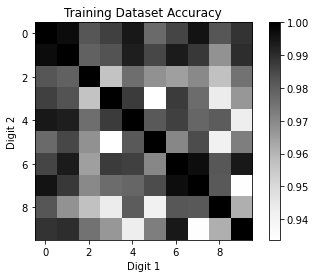

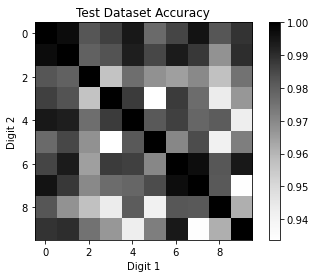

In [27]:
%matplotlib inline
plt.imshow(train_acc_mat, cmap="Greys")
plt.title("Training Dataset Accuracy")
plt.xlabel("Digit 1")
plt.ylabel("Digit 2")
plt.colorbar()
plt.show()
plt.imshow(test_acc_mat, cmap="Greys")
plt.title("Test Dataset Accuracy")
plt.xlabel("Digit 1")
plt.ylabel("Digit 2")
plt.colorbar()
plt.show()

In [31]:
def digit_trainer_multiple(digit_data, labels, num_features):
    U, S, V = np.linalg.svd(digit_data, full_matrices=False)
    U = U[:, 0:num_features]

    SV = np.diag(S) @ V

    included_digits = np.unique(labels)
    num_digits = len(included_digits)

    digits = []
    digits_mean = []

    for i in range(num_digits):
        digits.append(SV[0:num_features, labels == included_digits[i]])
        digits_mean.append(np.mean(digits[i], axis=1))

    all_digits_sum = 0
    num_samples = 0
    for i in range(num_digits):
        all_digits_sum += np.sum(digits[i], axis=1)
        num_samples += digits[i].shape[1]

    all_digits_mean = all_digits_sum / num_samples
    
    S_w = 0

    for j in range(num_digits):
        for i in range(digits[j].shape[1]):
            S_w += (digits[j][:, i] - digits_mean[j]).reshape(-1 ,1) @ (digits[j][:, i] - digits_mean[j]).reshape(-1, 1).T

    S_B = 0
    for j in range(num_digits):
        S_B += (digits_mean[j] - all_digits_mean).reshape(-1, 1) @ (digits_mean[j] - all_digits_mean).reshape(-1, 1).T


    eigenvalues, eigenvectors = sp.linalg.eig(S_B, S_w)
    max_eig_ind = np.argmax(np.abs(eigenvalues))
    w = eigenvectors[:, max_eig_ind]
    w = w / np.linalg.norm(w, ord=2)

    projected_digits = []

    for j in range(num_digits):
        projected_digits.append(w.T @ digits[j])

    projected_digits_mean = []
    for j in range(num_digits):
        projected_digits_mean.append(np.mean(projected_digits[j]))

    return U, S, V, projected_digits_mean, w, included_digits

def predict_multiple(data, U, projected_digits_mean, w, digits):
    prediction_val = w.T @ U.T @ data
    predictions = np.zeros(prediction_val.shape)
    for i in range(len(prediction_val)):
        digit_index = np.argmin(np.abs(prediction_val[i] - projected_digits_mean))
        predictions[i] = digits[digit_index]

    return predictions

# Taket the subset of the dataset provided that contains only the digits found in the parameter digits
def data_subset(data, labels, digits):
    subset_data = []
    subset_labels = []
    for digit in digits:
        subset_data.append(data[:, labels == digit])
        subset_labels.append(labels[labels == digit])
    
    return np.hstack(subset_data), np.hstack(subset_labels)
    

In [59]:
data, labels = data_subset(train_data, train_labels, [0, 1])

U, S, V, projected_digits_mean, w, digits = digit_trainer_multiple(data, labels, num_features=784)

predictions = predict_multiple(data, U, projected_digits_mean, w, digits)
print(accuracy(predictions, labels))

data, labels = data_subset(test_data, test_labels, digits)

predictions = predict_multiple(data, U, projected_digits_mean, w, digits)
print(accuracy(predictions, labels))

0.9313067508882747
0.9191489361702128


In [3]:
from sklearn import svm
svm_model = svm.SVC()
svm_model.fit(train_data.T[:, :], train_labels[:])

SVC()

In [4]:
svm_model.score(test_data.T[:, :], test_labels[:])

0.9792

In [5]:
from sklearn import tree
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(train_data.T[:, :], train_labels[:])

DecisionTreeClassifier()

In [6]:
tree_model.score(test_data.T[:, :], test_labels[:])

0.8734

In [40]:
svm_hardest = svm.SVC()
svm_hardest.fit(train_data.T[(train_labels == 3) | (train_labels == 5), :], train_labels[(train_labels == 3) | (train_labels == 5)])
svm_hardest.score(test_data.T[(test_labels == 3) | (test_labels == 5), :], test_labels[(test_labels == 3) | (test_labels == 5)])

0.9936908517350158

In [41]:
tree_hardest = tree.DecisionTreeClassifier()
tree_hardest.fit(train_data.T[(train_labels == 3) | (train_labels == 5), :], train_labels[(train_labels == 3) | (train_labels == 5)])
tree_hardest.score(test_data.T[(test_labels == 3) | (test_labels == 5), :], test_labels[(test_labels == 3) | (test_labels == 5)])

0.9574132492113565

In [42]:
svm_easiest = svm.SVC()
svm_easiest.fit(train_data.T[(train_labels == 0) | (train_labels == 1), :], train_labels[(train_labels == 0) | (train_labels == 1)])
svm_easiest.score(test_data.T[(test_labels == 0) | (test_labels == 1), :], test_labels[(test_labels == 0) | (test_labels == 1)])

0.9995271867612293

In [43]:
tree_easiest = tree.DecisionTreeClassifier()
tree_easiest.fit(train_data.T[(train_labels == 0) | (train_labels == 1), :], train_labels[(train_labels == 0) | (train_labels == 1)])
tree_easiest.score(test_data.T[(test_labels == 0) | (test_labels == 1), :], test_labels[(test_labels == 0) | (test_labels == 1)])

0.9966903073286052